## Nombre: Alexis Alva Nuñez
## ROL: 201530013-5

<figure>
  <br><img title="canales" alt="t" src="canales.png" ><br>
  <center><figcaption>Fig.1 Asignación de Canales </figcaption></center>
</figure>

Se busca simular el comportamiento de un sistema con una capacidad **C** de canales que se encuentra constantemente recibiendo **M** usuarios que quieren utilizar el enlace. Debido a que el sistema tiene una capacidad limitada comparada al número de usuarios que quieren ocuparlo ($C < M$) existe la probabilidad que en algún punto un usario se intente conectar y todos los canales se encuentren ocupados, ocurriendo un **bloqueo**.

La idea de esta primera tarea es buscar dicha **probabilidad de bloqueo** de que un usuario no pueda conectarse por congestión al enlace. 


<figure>
  <br><img title="criterio" alt="t" src="criterio.png" ><br>
  <center><figcaption>Fig.2 Diagrama de flujo de la simulación </figcaption></center>
</figure>

## Generación de tiempos aleatorios 

Para cada evento dentro de la FEL tenemos 2 variables almacenadas dentro, el *id* del evento y su *tiempo* de ocurrencia asociado en la simulación. El tiempo estará dado por el cálculo del tiempo actual en el simulador más un tiempo asociado por la distribución correspondiente, pero ¿Cómo sabemos que distribución aplicar?

Para esto tenemos que recordar las distribuciones $Exp(\lambda)$ y $Exp(\mu)$.
* $Exp(\lambda)$ con $\lambda$ tasa de llegada nos generará los tiempos aleatorios para usuarios que entran al enlace.

* $Exp(\mu)$ con $\mu$ tasa de salida que nos generará los tiempo aleatorios para usuarios que salen del enlace.

In [13]:
import numpy as np
# Generación de tiempos aleatorios Exp(lambda)
def randExp(lamb,size=1):    
    pt = np.random.rand(size)
    return (-1/lamb)*np.log(pt)

# Distribución exponencial Exp(lambda)
def expDist(lamb,x):
    return lamb*np.exp(-lamb*x)

## Inicialización de la simulación

En la función ```initilization(m, c, Lamb, Mu)```, se inicializan todos los parámetros necesarios para que la simulación pueda ser ejecutada, tales como:

* M - Cantidad de usuarios
* C - Cantidad de canales 
* $\lambda$ - Tasa de llegada de un usuario
* $\mu$ - Tasa de salida de un usuario 

Se deben elegir valores para dichas variables acorde a las siguientes condiciones para que ejecute correctamente su simulador: 

* $C < M$
* $ 0.1 \leqslant \frac{\lambda}{\mu} \leqslant 0.4 $ 

* Los eventos de llegada comprenderán el rango de *id = {0, ... , M-1}*

* Los eventos de salida comprenderán el rango de *id = {M, ... , 2M-1}*

In [14]:
from operator import itemgetter
import matplotlib.pyplot as plt

def initilization(m, c, Lamb, Mu):
    global M,C,lamb,mu # hacemos las variables globales para poder usarlas en otras funciones
    M = m
    C = c
    lamb = Lamb
    mu = Mu
    if ((lamb/mu < 0.1)or(lamb/mu > 0.4) or (C > M)): # revisamos que cumpla la condicion requerida en la tarea
        print("Ingrese unos valores validos para lambda")
        return
    else:
        global U, B ,arrivals
        B = arrivals = U = 0
        global FEL
        FEL = []
        for i in range(M): # recorremos la FEL y la vamos rellenando los usuarios que van a llegar
            tiempo = randExp(lamb) 
            FEL.append((i,tiempo))
        FEL.sort(key=itemgetter(1))
        return FEL

## Función de llegada

Esta función de llegada nos permitirá, actulizar los parametros de nuestra simulación, ya sea aumentar las llegadas en cada instante de tiempo, aumentar los bloqueos, además de que nos permitirá calendarizar nuevas llegadas.

In [15]:
def arrive(p_bloqueo):
    global arrivals, U, B
    arrivals += 1 # aumentamos las llegadas
    if U == C:
        B += 1 # aumentamos los bloqueos ya que la capacidad del sistema está a tope
        if (arrivals%sample==0): # veo si se cumple la condición para calcular la probabilidad de bloqueos en (bloqueos_actuales/arrivos_actuales) 
            list_arrives.append(arrivals) 
            p_bloqueo = p_bloqueo + (B/arrivals) # vamos acumulando la probabilidad de bloqueo
            #print("p_bloqueo:",p_bloqueo)
            #print("B:", B)
            #print("arrivals:", arrivals)
            list_bloqueos.append(p_bloqueo) # agregamos la probabilidad de bloqueo en una lista, para luego graficarla
        # Evento Arribo por bloqueo
        tiempoArribo = eventoActual[1] + randExp(lamb) # calculamos el nuevo tiempo de arribo ya que se bloqueo anteriormente
        FEL.append((eventoActual[0], tiempoArribo)) # agregamos la nueva llegada a la FEL
        FEL.sort(key=itemgetter(1)) # ordenamos la FEL
    else:
        U +=1  # aumentamos la cantidad de usuarios en el sistema
        # Evento Salida por atención
        tiempoSalida = eventoActual[1] + randExp(mu) # calculamos el tiempo de salida del usuario
        FEL.append((eventoActual[0]+M, tiempoSalida)) # agregamos el usuario a la FEL
        FEL.sort(key=itemgetter(1)) # ordenamos la FEL
    

## Función de salida 

Esta función nos permite actulizar la cantidad de usuarios en el sistema luego de que cumplen su tiempo en el, 
además de que les calculamos su nuevo tiempo de llegada.

In [16]:
def exit():
    global U
    U -= 1 #disminuimos la cantidad de usuarios en el sistema ya que salió del sistema
    # Evento Arribo por salida
    tiempoArribo = eventoActual[1] + randExp(lamb) # calculamos el nuevo tiempo de arribo
    FEL.append((eventoActual[0]-M, tiempoArribo)) # agregamos la nueva llegada a la FEL
    FEL.sort(key=itemgetter(1)) # ordenamos la FEL
    

## Llegadas = 10e2

Probabilidad de bloqueo:0.62


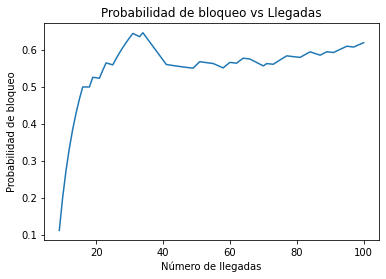

In [17]:
initilization(50,5,3,10) # (M, C, lambda, mu)
list_bloqueos = []
list_arrives = []
P_bloqueo = 0
P_bloqueo_total = 0
LLEGADAS_1 = 10**2
sample = LLEGADAS_1/100 # condición para tomar la muestra de la probablidad de bloqueo
while (arrivals < LLEGADAS_1):
    eventoActual = FEL.pop(0) # obtenemos el usuario al principio de la FEL
    #print(eventoActual)
    if eventoActual[0] < M: # comparamos el ID con la cantidad M para saber si es un arrivo o una salida
        # Evento de llegada
        arrive(P_bloqueo) # Usamos la función de arrivo, descrita previamente
        idEvento = eventoActual[0]
        #print(idEvento)
    else:
        # Evento de salida
        exit() # usamos la función de salida descrita previamente
        idEvento = eventoActual[0] - M
        #print(idEvento)
    #print(counter)
P_bloqueo_total_1 = B/LLEGADAS_1 # calculamos el bloqueo total
print("Probabilidad de bloqueo:{}".format(P_bloqueo_total_1))
#graficamos la probabilidad de bloqueo vs las llegadas
plt.plot(list_arrives, list_bloqueos)
plt.ylabel('Probabilidad de bloqueo')
plt.xlabel('Número de llegadas')
plt.title("Probabilidad de bloqueo vs Llegadas")
plt.show()

## Llegadas = 10e3

Probabilidad de bloqueo:0.683


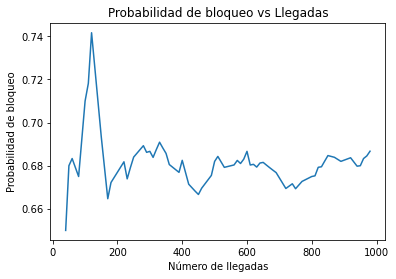

In [18]:
initilization(50,5,3,10) # (M, C, lambda, mu)
list_bloqueos = []
list_arrives = []
P_bloqueo = 0
P_bloqueo_total = 0
LLEGADAS_2 = 10**3
sample = LLEGADAS_2/100
while (arrivals < LLEGADAS_2):
    eventoActual = FEL.pop(0)
    #print(eventoActual)
    if eventoActual[0] < M:
        # Evento de llegada
        arrive(P_bloqueo)
        idEvento = eventoActual[0]
        #print(idEvento)
    else:
        # Evento de salida
        exit()
        idEvento = eventoActual[0] - M
        #print(idEvento)
    #print(counter)
P_bloqueo_total_2 = B/LLEGADAS_2
print("Probabilidad de bloqueo:{}".format(P_bloqueo_total_2))
plt.plot(list_arrives, list_bloqueos)
plt.ylabel('Probabilidad de bloqueo')
plt.xlabel('Número de llegadas')
plt.title("Probabilidad de bloqueo vs Llegadas")
plt.show()

## Llegadas = 10e4

Probabilidad de bloqueo:0.6656


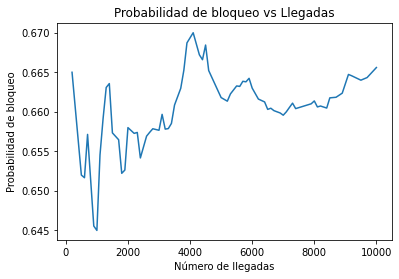

In [19]:
initilization(50,5,3,10) # (M, C, lambda, mu)
list_bloqueos = []
list_arrives = []
P_bloqueo = 0
P_bloqueo_total = 0
LLEGADAS_3 = 10**4
sample = LLEGADAS_3/100
while (arrivals < LLEGADAS_3):
    eventoActual = FEL.pop(0)
    #print(eventoActual)
    if eventoActual[0] < M:
        # Evento de llegada
        arrive(P_bloqueo)
        idEvento = eventoActual[0]
        #print(idEvento)
    else:
        # Evento de salida
        exit()
        idEvento = eventoActual[0] - M
        #print(idEvento)
    #print(counter)
P_bloqueo_total_3 = B/LLEGADAS_3
print("Probabilidad de bloqueo:{}".format(P_bloqueo_total_3))
plt.plot(list_arrives, list_bloqueos)
plt.ylabel('Probabilidad de bloqueo')
plt.xlabel('Número de llegadas')
plt.title("Probabilidad de bloqueo vs Llegadas")
plt.show()

## Llegadas = 10e5

Probabilidad de bloqueo:0.66583


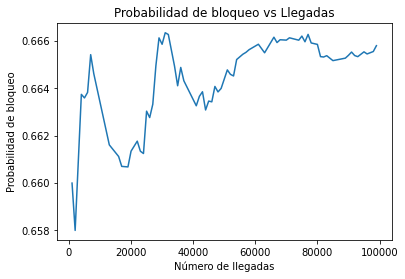

In [20]:
initilization(50,5,3,10) # (M, C, lambda, mu)
list_bloqueos = []
list_arrives = []
P_bloqueo = 0
P_bloqueo_total = 0
LLEGADAS_4 = 10**5
sample = LLEGADAS_4/100
while (arrivals < LLEGADAS_4):
    eventoActual = FEL.pop(0)
    #print(eventoActual)
    if eventoActual[0] < M:
        # Evento de llegada
        arrive(P_bloqueo)
        idEvento = eventoActual[0]
        #print(idEvento)
    else:
        # Evento de salida
        exit()
        idEvento = eventoActual[0] - M
        #print(idEvento)
    #print(counter)
P_bloqueo_total_4 = B/LLEGADAS_4
print("Probabilidad de bloqueo:{}".format(P_bloqueo_total_4))
plt.plot(list_arrives, list_bloqueos)
plt.ylabel('Probabilidad de bloqueo')
plt.xlabel('Número de llegadas')
plt.title("Probabilidad de bloqueo vs Llegadas")
plt.show()

## Llegadas = 10e6

Probabilidad de bloqueo:0.665203


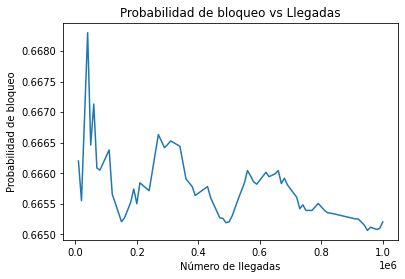

In [21]:
initilization(50,5,3,10) # (M, C, lambda, mu)
list_bloqueos = []
list_arrives = []
P_bloqueo = 0
P_bloqueo_total = 0
LLEGADAS_5= 10**6
sample = LLEGADAS_5/100
while (arrivals < LLEGADAS_5):
    eventoActual = FEL.pop(0)
    #print(eventoActual)
    if eventoActual[0] < M:
        # Evento de llegada
        arrive(P_bloqueo)
        idEvento = eventoActual[0]
        #print(idEvento)
    else:
        # Evento de salida
        exit()
        idEvento = eventoActual[0] - M
        #print(idEvento)
    #print(counter)
P_bloqueo_total_5 = B/LLEGADAS_5
print("Probabilidad de bloqueo:{}".format(P_bloqueo_total_5))
plt.plot(list_arrives, list_bloqueos)
plt.ylabel('Probabilidad de bloqueo')
plt.xlabel('Número de llegadas')
plt.title("Probabilidad de bloqueo vs Llegadas")
plt.show()

## Llegadas = 10e7

Probabilidad de bloqueo:0.6646423


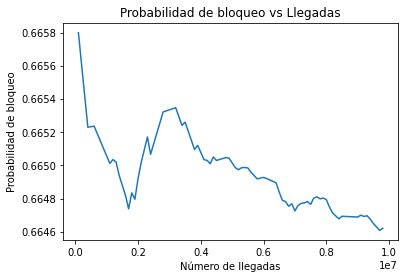

In [22]:
initilization(50,5,3,10) # (M, C, lambda, mu)
list_bloqueos = []
list_arrives = []
P_bloqueo = 0
P_bloqueo_total = 0
LLEGADAS_6 = 10**7
sample = LLEGADAS_6/100
while (arrivals < LLEGADAS_6):
    eventoActual = FEL.pop(0)
    #print(eventoActual)
    if eventoActual[0] < M:
        # Evento de llegada
        arrive(P_bloqueo)
        idEvento = eventoActual[0]
        #print(idEvento)
    else:
        # Evento de salida
        exit()
        idEvento = eventoActual[0] - M
        #print(idEvento)
    #print(counter)
P_bloqueo_total_6 = B/LLEGADAS_6
print("Probabilidad de bloqueo:{}".format(P_bloqueo_total_6))
plt.plot(list_arrives, list_bloqueos)
plt.ylabel('Probabilidad de bloqueo')
plt.xlabel('Número de llegadas')
plt.title("Probabilidad de bloqueo vs Llegadas")
plt.show()

## Llegadas = 10e8

Probabilidad de bloqueo:0.66495155


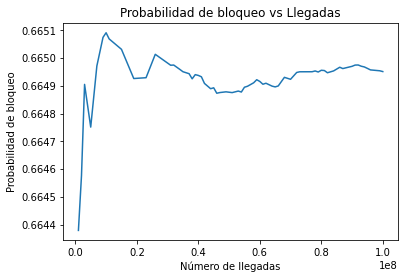

In [23]:
initilization(50,5,3,10) # (M, C, lambda, mu)
list_bloqueos = []
list_arrives = []
P_bloqueo = 0
P_bloqueo_total = 0
LLEGADAS_7 = 10**8
sample = LLEGADAS_7/100
while (arrivals < LLEGADAS_7):
    eventoActual = FEL.pop(0)
    #print(eventoActual)
    if eventoActual[0] < M:
        # Evento de llegada
        arrive(P_bloqueo)
        idEvento = eventoActual[0]
        #print(idEvento)
    else:
        # Evento de salida
        exit()
        idEvento = eventoActual[0] - M
        #print(idEvento)
    #print(counter)
P_bloqueo_total_7 = B/LLEGADAS_7
print("Probabilidad de bloqueo:{}".format(P_bloqueo_total_7))
plt.plot(list_arrives, list_bloqueos)
plt.ylabel('Probabilidad de bloqueo')
plt.xlabel('Número de llegadas')
plt.title("Probabilidad de bloqueo vs Llegadas")
plt.show()

# Grafico final

En este grafico mostramos, la probabilidad de bloqueo para la cantidad de llegadas calculadas anteriormente

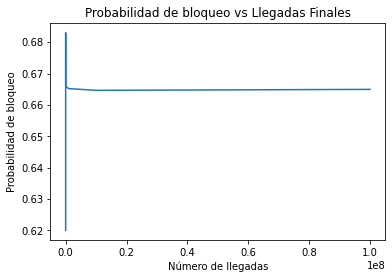

In [24]:
list_blocked_prob = [P_bloqueo_total_1, P_bloqueo_total_2, P_bloqueo_total_3, P_bloqueo_total_4, P_bloqueo_total_5,
                        P_bloqueo_total_6, P_bloqueo_total_7]
list_blocked_arrivals = [LLEGADAS_1, LLEGADAS_2, LLEGADAS_3, LLEGADAS_4, LLEGADAS_5, LLEGADAS_6, LLEGADAS_7]
plt.plot(list_blocked_arrivals, list_blocked_prob)
plt.ylabel('Probabilidad de bloqueo')
plt.xlabel('Número de llegadas')
plt.title("Probabilidad de bloqueo vs Llegadas Finales")
plt.show()